In [2]:
# MNIST Handwritten Digit Classification
import os
import torch
import torch.nn as nn               # to load neural network functionality
import torch.nn.functional as nnF       # Adds efficiency
from torch.utils.data import DataLoader # Data loading in batches
from torchvision import datasets, transforms
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix # For evaluating results
import matplotlib.pyplot as plt
%matplotlib inline
import time
torch.manual_seed(2002) # setting seed for consistent results


In [3]:
transformer = transforms.ToTensor()
#print(os.getcwd()) # For debugging :D lol folder problems
train_data = datasets.MNIST(root='\data', train=True, download=False, transform=transformer) # loading the training data
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: \data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data = datasets.MNIST(root='\data', train=False, download=False, transform=transformer) # Loading the test data
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: \data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
image, label = train_data[18]
print('Image shape:', image.shape, '\nImage Label:', label)

Image shape: torch.Size([1, 28, 28]) 
Image Label: 6


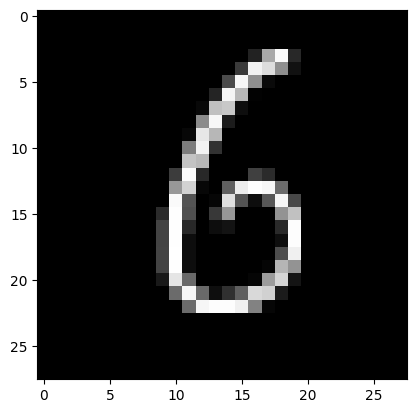

In [6]:
plt.imshow(image.reshape((28,28)), cmap="gray") # Gray colormap for only one channel

In [7]:
# Establishing data loaders for batch data loading for training and testing sets
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [8]:
class MP(nn.Module): # MP = short for MultilayerPerceptron
    # The input size is the flattened 2D-image array, from [[28,28]] -> [784] or smth
    # Takes 120 inputs and has 84 neurons, output size is 10, since 0-9 is the range we are dealing with.
    def __init__(self, input_size=784, output_size=10, layers=[120,84]):
        super().__init__()
        # With PyTorch, there is no need to create a separate input layer, it handles the input for you :)
        self.hl1 = nn.Linear(input_size, layers[0])  # Hidden layer 1 for computation
        self.hl2 = nn.Linear(layers[0], layers[1])   # Hidden layer 2   
        self.ol = nn.Linear(layers[1], output_size) # Output layer

    def forward(self, X):
        X = nnF.relu(self.hl1(X))
        X = nnF.relu(self.hl2(X))
        X = self.ol(X)
        return nnF.log_softmax(X, dim=1) # Applying a softmax limit with a logarithm function
        

In [9]:
model = MP()
print(model)

MP(
  (hl1): Linear(in_features=784, out_features=120, bias=True)
  (hl2): Linear(in_features=120, out_features=84, bias=True)
  (ol): Linear(in_features=84, out_features=10, bias=True)
)


In [10]:
# Optimizing the model for trying to minimize loss throughtout iterations
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
for images, labels in train_loader:
    print("Batch shape at start:", images.size())
    break
print("Batch shape after flattening:", images.view(100, -1).size())

Batch shape at start: torch.Size([100, 1, 28, 28])
Batch shape after flattening: torch.Size([100, 784])


In [12]:
# Training the model
n_epochs = 20 # Number of epochs to train the model on

model.train() # Preparing model for training

loss_values = [] # Store loss values at each epoch

for epoch in range(n_epochs):
    # Monitorin training loss
    train_loss = 0.0
    
    for data, target in train_loader:
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        data = data.view(data.shape[0], -1) # Reshaping the data
        # Compute predicted outputs by passing inputs to the model
        output = model(data)
        loss = criteria(output, target)
        # Compute gradient of the loss with respect to the model parameters
        loss.backward()
        # Perform a single parameter update
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
    
    # Print training stats and calculate average loss between epochs
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
    loss_values.append(train_loss)


Epoch: 1 	Training Loss: 0.247176
Epoch: 2 	Training Loss: 0.125983
Epoch: 3 	Training Loss: 0.108589
Epoch: 4 	Training Loss: 0.098765
Epoch: 5 	Training Loss: 0.088202
Epoch: 6 	Training Loss: 0.086886
Epoch: 7 	Training Loss: 0.082225
Epoch: 8 	Training Loss: 0.082272
Epoch: 9 	Training Loss: 0.071360
Epoch: 10 	Training Loss: 0.069504
Epoch: 11 	Training Loss: 0.063543
Epoch: 12 	Training Loss: 0.067822
Epoch: 13 	Training Loss: 0.060642
Epoch: 14 	Training Loss: 0.064335
Epoch: 15 	Training Loss: 0.061347
Epoch: 16 	Training Loss: 0.051094
Epoch: 17 	Training Loss: 0.061600
Epoch: 18 	Training Loss: 0.048527
Epoch: 19 	Training Loss: 0.050951
Epoch: 20 	Training Loss: 0.058227


In [27]:
# Testing the trained network
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # Sets the model in to evaluation mode

with torch.no_grad(): # Turns off gradients fo validation, saves memory
    for data, target in test_loader:
        data = data.view(data.shape[0], -1)
        output = model(data)
        loss = criteria(output, target)
        test_loss += loss.item()*data.size(0)
        # Converting output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # Comparing predictions to the True label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        
        for i in range(500): # Test batch size as range
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

# Loop over the range of 10 for each of the numbers represented
for i in range(10):
    # If there are any examples of this class in the test set
    if class_total[i] > 0:
        # Print the test accuracy for this class. The accuracy is calculated as the number of correct predictions 
        # for this class divided by the total number of examples of this class in the test set.
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        # If there are no examples of this class in the test set, print 'N/A'
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# After going through all the classes, print the overall test accuracy. This is calculated as the total number of 
# correct predictions across all classes divided by the total number of examples across all classes in the test set.
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.199966

Test Accuracy of     0: 97% (959/980)
Test Accuracy of     1: 98% (1119/1135)
Test Accuracy of     2: 96% (997/1032)
Test Accuracy of     3: 97% (989/1010)
Test Accuracy of     4: 97% (958/982)
Test Accuracy of     5: 96% (862/892)
Test Accuracy of     6: 97% (933/958)
Test Accuracy of     7: 96% (987/1028)
Test Accuracy of     8: 98% (956/974)
Test Accuracy of     9: 93% (943/1009)

Test Accuracy (Overall): 97% (9703/10000)


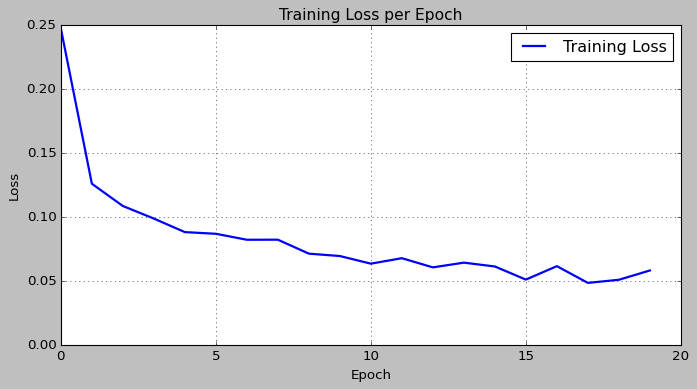

In [32]:
# Plotting the training loss 
plt.style.use('classic')
plt.figure(figsize=(10,5))
plt.plot(loss_values, 'b-', linewidth=2)
plt.grid(True)

# Add title and labels with specific font sizes
plt.title("Training Loss per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)

# Add a legend
plt.legend(['Training Loss'], loc='upper right')

# Show the plot
plt.show()